## Apply wavelet to iHub data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as scsig
import pandas as pd

In [2]:
from laser_dataset import LaserDataInteractor

## (0) Load the metadata 

In [3]:
path_meta = '/Volumes/Sandisk_SD/Work/IZFP/Laser/2023_iHub/00_Versuchsplan_iHub.xlsx'
metadf = pd.read_excel(
    path_meta,
    sheet_name=1,
    usecols="C:G, I, R,S",
    nrows=71,
    decimal=','
)

## (1) Load QASS data

In [4]:
# Path to the data
path_qass = '/Volumes/Sandisk_SD/Work/IZFP/Laser/2023_iHub/02_QASS'

# Example trial
dataID = 18
row = dataID - 1
fname_dew = metadf['DEWETRON'][row]
qassNo = str(metadf['QASS'][row]).zfill(3)

# Measurement parameters
fs_qass = 6.25*10**6 # [Hz]

#---- Load the raw data
interactor = LaserDataInteractor()
interactor.df = metadf
interactor.df_row = fname_dew
s1 = interactor.load(chNo=1, path=path_qass)
s2 = interactor.load(chNo=2, path=path_qass)
s3 = interactor.load(chNo=3, path=path_qass)

## (2) Delay correction

In [5]:
# Load the delay
path_delay = '/Volumes/Sandisk_SD/Work/IZFP/Laser/2023_iHub/04_delays'
info_df = pd.read_csv(f'{path_delay}/delays_QASS.csv') 
delay = info_df['delay[s]'][info_df['QASS'] == int(qassNo)].item() #[s]
#N = int(delay/
print(f'delay = {round(10**3*delay, 2)}ms')

delay = 7.7ms


In [6]:
t_start_cam = metadf[metadf['DEWETRON']==fname_dew]['tstart [s]'].item()
t_end_cam = metadf[metadf['DEWETRON']==fname_dew]['tend [s]'].item()
t_start_qass = t_start_cam - delay
t_end_qass = t_end_cam - delay

print(f't_start: HD camera = {t_start_cam}s, QASS = {t_start_qass}s')
print(f't_end: HD camera = {t_end_cam}s, QASS = {t_end_qass}s')


t_start: HD camera = 0.25s, QASS = 0.2422995s
t_end: HD camera = 1.0581s, QASS = 1.0503995s


In [7]:
# Dataframe for the selected trial
trial_df = metadf[metadf['DEWETRON']==fname_dew].reset_index(drop=True)

del metadf
trial_df

,HV-Data,QASS,SoundBook,DEWETRON,Probe,Spalt [mm],tstart [s],tend [s]
0,18_0_3_Spalt_pneu,62,iHub2023_018,18_0_3_Spalt_pneu,standard,0.3,0.25,1.0581


## (3) Reduce the data size
why? Because the CWT in scipy uses the input data length as the length of the wavelet. As our data is way too large, CWT cannot be computed. 

In [8]:
# (3.1) Downsampling
def downsample(sig, _ds):
    # Reshape the signal into an array
    col = int(_ds)
    row = int(len(sig)/_ds)
    arr = np.reshape(sig, (row, col), order='F')
    # Take the average
    return np.mean(arr, axis=1)

ds = 5 # dwonsampling rate
s1_ds = downsample(s1, ds)
s2_ds = downsample(s2, ds)
s3_ds = downsample(s3, ds)
print(f'Down-sampled the signal length: before = {len(s1)}, after = {len(s1_ds)}')

# New sampling rate
fs = fs_qass / ds

Down-sampled the signal length: before = 18600960, after = 3720192


In [9]:
# Trim the signals (because the data size is too large)
T = 0.6 # [s], duration
t1 = 0.0#round(t_start_qass - 500/fs, 9) # starting point, [s]
idx1 = int(t1* fs)
t2 = round(t1 + T, 9) # end point, [s]
idx2 = int(t2* fs)
print(f'Trimming starts @t1 = {t1}s, and ends @t2 = {t2}s')
print(f'Trimmed the signal length: before = {len(s1_ds)}, after = {idx2 - idx1}')

# -> formatting an array for plots
S = [s1_ds[idx1:idx2], s2_ds[idx1:idx2], s3_ds[idx1:idx2]]
t = 1/fs* np.arange(0, len(S[0]))

Trimming starts @t1 = 0.0s, and ends @t2 = 0.6s
Trimmed the signal length: before = 3720192, after = 750000


In [10]:
del s1, s2, s3

## (3) Wavelet analysis

In [11]:
# Better selection of the "fundamental frequencies" of the wavelets
def wavelet_bp_freq(_fs, n):
    """
    To ensure the wavelet dyadic scaling is 2**k (Cf: Book by Mallat, p.28),
    its fundamental frequency needs to be computed as 
    
    Parameters
    ----------
    _fs: float [Hz]
        Sampling frequency
    n: int
        Number of bands
    """
    # Compute the bins (i.e. 0, f_Ny/64, f_Ny/32, f_Ny/16 ... f_Ny/2, f_Ny)
    f_Ny = _fs / 2 # Nyquest frequency
    denom = 2**(np.arange(0, n, dtype=float))
    bins = np.flipud(np.concatenate((f_Ny/denom, np.zeros(1))))
    # Wavelet "fundamental frequencies": center of each bin
    #f = (bins[:-1:] + bins[1::]) / 2
    f = bins[1:]
    return f
     

In [12]:
# -> how to choose the length of the wavelet?
# -> with scsig.cwt: the length of the input time-domain data is automatically set as the length of the wavelet and 
# cannot be specified externally
w = 5.0
freq = wavelet_bp_freq(fs, 30)#np.linspace(1, fs/2, 100)
widths = w*fs / (2*freq*np.pi)

In [13]:
freq

array([1.16415322e-03, 2.32830644e-03, 4.65661287e-03, 9.31322575e-03,
       1.86264515e-02, 3.72529030e-02, 7.45058060e-02, 1.49011612e-01,
       2.98023224e-01, 5.96046448e-01, 1.19209290e+00, 2.38418579e+00,
       4.76837158e+00, 9.53674316e+00, 1.90734863e+01, 3.81469727e+01,
       7.62939453e+01, 1.52587891e+02, 3.05175781e+02, 6.10351562e+02,
       1.22070312e+03, 2.44140625e+03, 4.88281250e+03, 9.76562500e+03,
       1.95312500e+04, 3.90625000e+04, 7.81250000e+04, 1.56250000e+05,
       3.12500000e+05, 6.25000000e+05])

In [14]:
widths

array([8.54456594e+08, 4.27228297e+08, 2.13614149e+08, 1.06807074e+08,
       5.34035372e+07, 2.67017686e+07, 1.33508843e+07, 6.67544214e+06,
       3.33772107e+06, 1.66886054e+06, 8.34430268e+05, 4.17215134e+05,
       2.08607567e+05, 1.04303784e+05, 5.21518918e+04, 2.60759459e+04,
       1.30379729e+04, 6.51898647e+03, 3.25949323e+03, 1.62974662e+03,
       8.14873309e+02, 4.07436654e+02, 2.03718327e+02, 1.01859164e+02,
       5.09295818e+01, 2.54647909e+01, 1.27323954e+01, 6.36619772e+00,
       3.18309886e+00, 1.59154943e+00])

In [28]:
# Channel 1
cwtm = scsig.cwt(S[0], scsig.morlet2, widths, w=w)

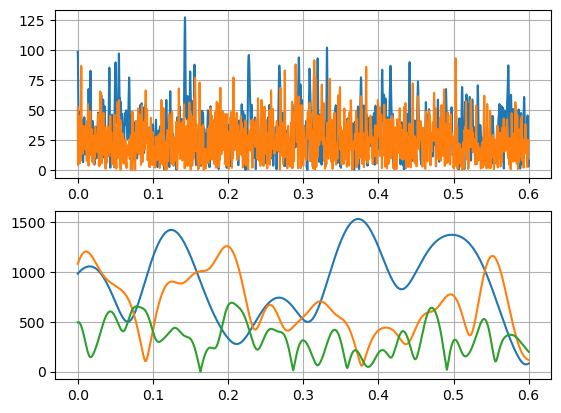

In [59]:
%matplotlib inline

K = int(cwtm.shape[1]/1) # Shortened x-axis size 
start = 0

fig, (ax0, ax1) = plt.subplots(2, 1)

ax0.plot(t1+t, np.abs(cwtm[20:22, start:start+K].T))
ax0.grid(True)

ax1.plot(t1+t, np.abs(cwtm[14:17, start:start+K].T))
ax1.grid(True)


plt.show()

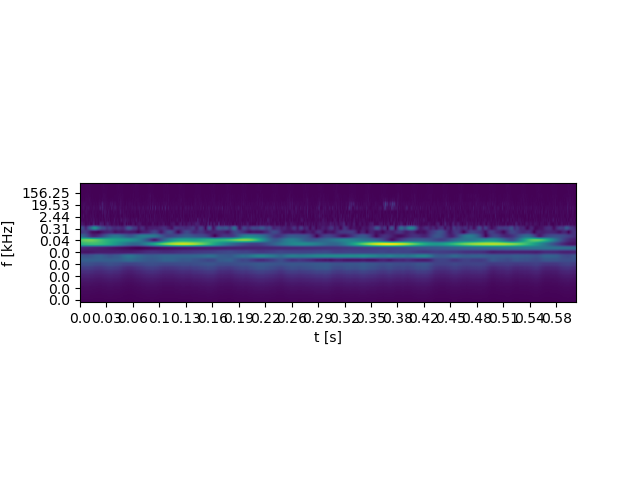

In [30]:
%matplotlib widget
#%matplotlib inline
K = int(cwtm.shape[1]/1) # Shortened x-axis size (-> correspond to approx. T/2)

fig, ax = plt.subplots(1, 1)

start = 0
ax.imshow(
    np.abs(cwtm[:, start:start+K]), 
    cmap='viridis', aspect=6000.0)

# Make it more pretty
#--- time axis
xticks = np.arange(0, K, 40000) #[ms]
xticklabels = np.around(t1 + xticks/fs, 2) #[ms]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_xlabel('t [s]')

#--- freq axis
yticks = np.arange(0, len(freq), 3)
yticklabels = np.around(10**-3* freq[::3], 2)
ax.invert_yaxis()
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
#ax.set_ylim(bottom=0.0, top=250.0)
ax.set_ylabel('f [kHz]')

plt.show()

In [ ]:
raise ValueError('Stop!')

In [ ]:
%matplotlib widget
# Split the results into four sections (otherwise matplotlib cannot display the results)
K = int(cwtm.shape[1]/4) # Shortened x-axis size (-> correspond to approx. T/4)

fig, axs = plt.subplots(4, 1)

for row, ax in enumerate(axs.flatten()):
    start = int(row*K)
    # Use pcolormesh to specify the y-axis
    ax.pcolormesh(
        t[start:start+K], freq, 
        np.abs(cwtm[:, start:start+K]), 
        cmap='viridis', shading='gouraud')
    ax.set_title(f'{row*0.2}...{(row+1)*0.2}s')

plt.show()

In [31]:
plt.close('all')